## Port of refactored CHIME model to simple Jupyter notebook

Now that app has been entirely:

* OO'd, refactored, and super modularized, 
* and some important resource bugs fixed

Let's try to use via a Notebook and simple script.

ps://github.com/CodeForPhilly/chime

I've added tons of code comments and other descriptive text throughout the notebook to help others understand exactly how this works and how we might adapt it for our use.

In [7]:
from datetime import datetime

from pandas import DataFrame

from penn_chime.parameters import Parameters
from penn_chime.models import SimSirModel
from penn_chime.utils import RateLos

In [8]:
import pandas as pd
import numpy as np
import math

from IPython.display import display, Markdown, Latex
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

## Input parameters

### Define region to model
The following input parameters define the region we are modeling in any given scenario.

In [4]:
# TODO: Just made these up. Need real counties and pops.
# Via KR@BH on 2020-03-22
wayne = 1778396
oakland = 1248141
macomb = 867502
genesee = 414657
washtenaw = 326058
saintclair = 158313
monroe = 153436
lapeer = 79723
S_default = wayne + oakland + macomb + genesee + washtenaw + saintclair + monroe + lapeer

known_infections = 787  # update daily
known_cases = 457  # update daily

market_share = 28.0
#

## SIR and resource model input parameters

In [5]:
# How many do days you want to run this for?
n_days = 120

# Currently Hospitalized COVID-19 Patients
current_hosp = known_cases

# Doubling time before social distancing (days)
doubling_time = 6

# Social distancing (% reduction in social contact)
relative_contact_rate = 0.5

# Hospitalization %(total infections)
hosp_rate = 0.05

# ICU %(total infections)
icu_rate = 0.02

# Ventilated %(total infections)
vent_rate = 0.01
# Hospital average Length of Stay (days)
hosp_los = 7
# ICU average Length of Stay (days)
icu_los = 9
# Vent average Length of Stay (days)
vent_los = 10

# Hospital Market Share (%)
BH_market_share = market_share / 100

# Regional Population
S = S_default

# Currently Known Regional Infections (only used to compute detection rate - does not change projections
initial_infections = known_infections

## Compute values needed for modeling
Based on input parameter values, we can compute a bunch of key intermediate values that are used to drive the simulation and the resource computations. This is where we do stuff that needs to be computed before main simulation can run.

Good overview of SIR model available at https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology.

In [6]:
# Seems like estimating initial number of total infections in the population *region*
# we are modeling (i.e. that we put population numbers in above) by inferring from the
# number we have in hospital and then inflating by both our market share and then
# the hospitalization rate of infecteds. So, total_infections is in our entire
# region.

total_infections = current_hosp / BH_market_share / hosp_rate

# Estimate prob[detection | infected]. Will be used to initialize size of I.
detection_prob = initial_infections / total_infections

# Compute initial values for S, I, and R (susceptible, infectious, recovered)
# Note that initial value for S was set up above based on input params
# I is initialized by reflecting the fact that there are a bunch of undetected
# cases out there and R is initially set to 0.
S, I, R = S, initial_infections / detection_prob, 0

# Since this model lets user input the doubling time (time for I -> 2I), we can back into the
# implied intrinsic growth rate of the pandemic. We'll use this below to get to 
# key model terms like "basic reproduction number"
intrinsic_growth_rate = 2 ** (1 / doubling_time) - 1

recovery_days = 14.0 # Hmm, this is hard coded. Probably should get moved up into input params.
# mean recovery rate, gamma, (in 1/days).
gamma = 1 / recovery_days

# Contact rate, beta
beta = (
    intrinsic_growth_rate + gamma
) / S * (1-relative_contact_rate) # {rate based on doubling time} / {initial S}

# Now can compute the "basic reproduction number". It's kind of like the
# rho term in queueing models. When > 1, epidemic grows.
r_t = beta / gamma * S # r_t is r_0 after distancing
r_naught = r_t / (1-relative_contact_rate)
doubling_time_t = 1/np.log2(beta*S - gamma +1) # doubling time after distancing

## Credits and illustrating rendering
I wanted to keep the UPenn credits and info as well as show how easy it is to render and display Markdown in a Jupyter notebook.

In [7]:
display(Markdown(
        """*This tool was developed by the [Predictive Healthcare team](http://predictivehealthcare.pennmedicine.org/) at
    Penn Medicine. For questions and comments please see our
    [contact page](http://predictivehealthcare.pennmedicine.org/contact/). Code can be found on [Github](https://github.com/pennsignals/chime).
    Join our [Slack channel](https://codeforphilly.org/chat?channel=covid19-chime-penn) if you would like to get involved!*"""))


*This tool was developed by the [Predictive Healthcare team](http://predictivehealthcare.pennmedicine.org/) at
    Penn Medicine. For questions and comments please see our
    [contact page](http://predictivehealthcare.pennmedicine.org/contact/). Code can be found on [Github](https://github.com/pennsignals/chime).
    Join our [Slack channel](https://codeforphilly.org/chat?channel=covid19-chime-penn) if you would like to get involved!*

In [8]:
display(Markdown("""The estimated number of currently infected individuals is **{total_infections:.0f}**. The **{initial_infections}**
    confirmed cases in the region imply a **{detection_prob:.0%}** rate of detection. This is based on current inputs for
    Hospitalizations (**{current_hosp}**), Hospitalization rate (**{hosp_rate:.0%}**), Region size (**{S}**),
    and Hospital market share (**{BH_market_share:.0%}**).

An initial doubling time of **{doubling_time}** days and a recovery time of **{recovery_days}** days imply an $R_0$ of
**{r_naught:.2f}**.

**Mitigation**: A **{relative_contact_rate:.0%}** reduction in social contact after the onset of the outbreak reduces the doubling time to **{doubling_time_t:.1f}** days, implying an effective $R_t$ of **${r_t:.2f}$**.
""".format(
        total_infections=total_infections,
        initial_infections=initial_infections,
        detection_prob=detection_prob,
        current_hosp=current_hosp,
        hosp_rate=hosp_rate,
        S=S,
        BH_market_share=BH_market_share,
        recovery_days=recovery_days,
        r_naught=r_naught,
        doubling_time=doubling_time,
        relative_contact_rate=relative_contact_rate,
        r_t=r_t,
        doubling_time_t=doubling_time_t
    )))

The estimated number of currently infected individuals is **32643**. The **787**
    confirmed cases in the region imply a **2%** rate of detection. This is based on current inputs for
    Hospitalizations (**457**), Hospitalization rate (**5%**), Region size (**5026226**),
    and Hospital market share (**28%**).

An initial doubling time of **6** days and a recovery time of **14.0** days imply an $R_0$ of
**2.71**.

**Mitigation**: A **50%** reduction in social contact after the onset of the outbreak reduces the doubling time to **27.5** days, implying an effective $R_t$ of **$1.36$**.


## The SIR Model
For now just pasting in the model description code from the web app. **IMPORTANT: See web app at https://penn-chime.phl.io/ for readable version - it's got very helpful description of how this model works. You need to CHECK THE BOX labelled "Show more info about this tool".**

### Single time step of model
The following function updates S, I and R for a single time step. It will get called repeatedly from main simulation loop.

In [9]:
# The SIR model, one time step
def sir(y, beta, gamma, N):
    S, I, R = y
    Sn = (-beta * S * I) + S
    In = (beta * S * I - gamma * I) + I
    Rn = gamma * I + R
    if Sn < 0:
        Sn = 0
    if In < 0:
        In = 0
    if Rn < 0:
        Rn = 0

    scale = N / (Sn + In + Rn)
    return Sn * scale, In * scale, Rn * scale

### Main simulation function
Initialize with our current values of S, I, and R based on user input parameters and then loop for a specified number of days. 

Looks like there's a "hook" to be able to model decay in $\beta$, the effective contact rate, but the default is to assume no decay. This allows being able to model things like changes in basic virulence of the virus.

This `sim_sir()` function will get called from the next bit of main code in the next cell.

In [10]:
# Run the SIR model forward in time
def sim_sir(S, I, R, beta, gamma, n_days, beta_decay=None):
    N = S + I + R
    s, i, r = [S], [I], [R]
    for day in range(n_days):
        y = S, I, R
        S, I, R = sir(y, beta, gamma, N)
        if beta_decay:
            beta = beta * (1 - beta_decay)
        s.append(S)
        i.append(I)
        r.append(R)

    s, i, r = np.array(s), np.array(i), np.array(r)
    return s, i, r

Now we are ready to run the simulation. In the code below, the line that actually calls the sim function is:

    s, i, r = sim_sir(S, I, R, beta, gamma, n_days, beta_decay=beta_decay)
    
So, the result is a tuple of numpy arrays representing the size of S, I, and R at each time step. We'll then be able to use these to drive resource related calculations that depend on them.


In [11]:
# Assume no beta decay for now.
beta_decay = 0.0

# Call the main simulation function. 
s, i, r = sim_sir(S, I, R, beta, gamma, n_days, beta_decay=beta_decay)

# Compute arrays of resource use at each time step
# Note that the three resources included in the base model are just using
# "multipliers" to compute hospital specific guesstimates of resource needs.
# A similar kind of thing might be appropriate for many resources such
# as needs for numbers of certain kinds of staff.
hosp = i * hosp_rate * BH_market_share
icu = i * icu_rate * BH_market_share
vent = i * vent_rate * BH_market_share

# Now read to create master DataFrame to drive plots

# Need array of the days
days = np.array(range(0, n_days + 1))

# Combine arrays for days and all resource related arrays.
# Obviously, as new resource computations are added above,
# need to add those arrays to data_list
data_list = [days, hosp, icu, vent]

# Create a dictionary from data_list to use to easily create pandas DataFrame.
data_dict = dict(zip(["day", "hosp", "icu", "vent"], data_list))

# Create the main DataFrame containing resource projections.
projection = pd.DataFrame.from_dict(data_dict)

The variable `projection` contains the pandas dataframe that drives the graphs. As you add more resources beyond just vents and ICUs, then you just make sure you add the arrays to the `data_list` in the code chunk above.

In [12]:
projection

,day,hosp,icu,vent
0,0,457.000000,182.800000,91.400000
1,1,468.661149,187.464460,93.732230
2,2,480.591247,192.236499,96.118249
3,3,492.794970,197.117988,98.558994
4,4,505.276993,202.110797,101.055399
...,...,...,...,...
116,116,3144.361154,1257.744462,628.872231
117,117,3150.530430,1260.212172,630.106086
118,118,3155.710167,1262.284067,631.142033
119,119,3159.897516,1263.959006,631.979503


### New Admissions
Projected number of **daily** COVID-19 admissions

In [13]:
# New cases (computing lag 1 difference)
projection_admits = projection.iloc[:-1, :] - projection.shift(1)
projection_admits[projection_admits < 0] = 0

plot_projection_days = n_days - 10
projection_admits["day"] = range(projection_admits.shape[0])

In [14]:
projection_admits

,day,hosp,icu,vent
0,0,NaN,NaN,NaN
1,1,11.661149,4.664460,2.332230
2,2,11.930098,4.772039,2.386020
3,3,12.203723,4.881489,2.440745
4,4,12.482022,4.992809,2.496404
...,...,...,...,...
116,116,7.154696,2.861879,1.430939
117,117,6.169276,2.467711,1.233855
118,118,5.179737,2.071895,1.035947
119,119,4.187349,1.674940,0.837470


Obviously, you can drive graphs from the `projection_admits` dataframe.

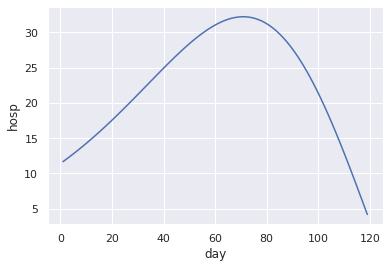

In [34]:
sns.lineplot(x="day", y="hosp", data=projection_admits);

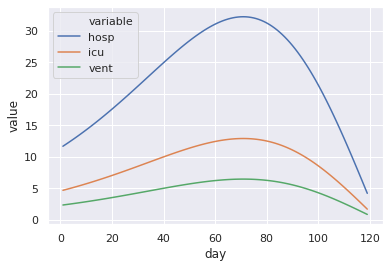

In [35]:
sns.lineplot(x='day', y='value', hue='variable', 
             data=pd.melt(projection_admits, ['day']));

### Census
Census of the COVID-19 related resources we are tracking.

The following function I left exactly as is from the UPenn model. Need
to dig into it in more detail to best understand how to incorporate
new resources. We might want to have a separate function that does
similar thing for any rebsources we add.

In [41]:
los = hosp_los
projection_admits.cumsum()

,day,hosp,icu,vent
0,0,NaN,NaN,NaN
1,1,11.661149,4.664460,2.332230
2,3,23.591247,9.436499,4.718249
3,6,35.794970,14.317988,7.158994
4,10,48.276993,19.310797,9.655399
...,...,...,...,...
116,6786,2687.361154,1074.944462,537.472231
117,6903,2693.530430,1077.412172,538.706086
118,7021,2698.710167,1079.484067,539.742033
119,7140,2702.897516,1081.159006,540.579503


In [42]:
# This should select rows 0:end-los and represents how many people
# would be there if no one ever left
projection_admits.cumsum().iloc[:-los, :]

,day,hosp,icu,vent
0,0,NaN,NaN,NaN
1,1,11.661149,4.664460,2.332230
2,3,23.591247,9.436499,4.718249
3,6,35.794970,14.317988,7.158994
4,10,48.276993,19.310797,9.655399
...,...,...,...,...
109,5995,2616.973560,1046.789424,523.394712
110,6105,2629.884026,1051.953610,525.976805
111,6216,2641.860019,1056.744008,528.372004
112,6328,2652.889995,1061.155998,530.577999


In [23]:
def _census_table(projection_admits, hosp_los, icu_los, vent_los) -> pd.DataFrame:
    """ALOS for each category of COVID-19 case (total guesses)"""

    los_dict = {
        "hosp": hosp_los,
        "icu": icu_los,
        "vent": vent_los,
    }

    census_dict = dict()
    for k, los in los_dict.items():
        census = (
            projection_admits.cumsum().iloc[:-los, :]
            - projection_admits.cumsum().shift(los).fillna(0)
        ).apply(np.ceil)
        census_dict[k] = census[k]


    census_df = pd.DataFrame(census_dict)
    census_df["day"] = census_df.index
    census_df = census_df[["day", "hosp", "icu", "vent"]]

    census_table = census_df[np.mod(census_df.index, 7) == 0].copy()
    census_table.index = range(census_table.shape[0])
    census_table.loc[0, :] = 0
    census_table = census_table.dropna().astype(int)

    # Modified following lines to convert NaN to 0 in first row of census_df
    # and to return the full census_df along with the table that only contains
    # every 7 days.
    census_df.loc[0, :] = 0
    return census_table, census_df

census_table, projection_census = _census_table(projection_admits, hosp_los, icu_los, vent_los)

In [21]:
census_table

,day,hosp,icu,vent
0,0,0,0,0
1,7,88,35,18
2,14,102,52,29
3,21,119,60,33
4,28,136,69,38
5,35,154,78,43
6,42,172,88,48
7,49,190,97,54
8,56,205,105,58
9,63,218,111,62


In [24]:
projection_census.head(30)

,day,hosp,icu,vent
0,0,0.0,0.0,0.0
1,1,12.0,5.0,3.0
2,2,24.0,10.0,5.0
3,3,36.0,15.0,8.0
4,4,49.0,20.0,10.0
5,5,62.0,25.0,13.0
6,6,75.0,30.0,15.0
7,7,88.0,35.0,18.0
8,8,90.0,41.0,21.0
9,9,92.0,47.0,24.0


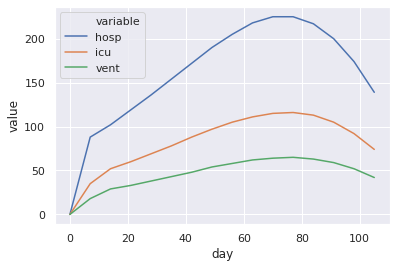

In [38]:
sns.lineplot(x='day', y='value', hue='variable', 
             data=pd.melt(census_table, ['day']));

In [26]:
test = pd.concat([projection_admits, projection_census], axis=1)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 0 to 120
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     121 non-null    int64  
 1   hosp    119 non-null    float64
 2   icu     119 non-null    float64
 3   vent    119 non-null    float64
 4   day     121 non-null    int64  
 5   hosp    114 non-null    float64
 6   icu     112 non-null    float64
 7   vent    111 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 13.5 KB


In [33]:
projection_resources = projection_census.copy()

census_rename_dict = {
    "hosp": 'hosp_census',
    "icu": 'icu_census',
    "vent": 'vent_census',
}

projection_resources = projection_resources.rename(census_rename_dict, axis='columns')
print(projection_resources)

dfs_to_concat = [projection_resources, projection_admits.iloc[:, 1:]]
projection_resources = pd.concat(dfs_to_concat, axis=1)

admit_rename_dict = {
    "hosp": 'hosp_admit',
    "icu": 'icu_admit',
    "vent": 'vent_admit',
}
projection_resources = projection_resources.rename(admit_rename_dict, axis='columns')

     day  hosp_census  icu_census  vent_census
0      0          0.0         0.0          0.0
1      1         12.0         5.0          3.0
2      2         24.0        10.0          5.0
3      3         36.0        15.0          8.0
4      4         49.0        20.0         10.0
..   ...          ...         ...          ...
116  116          NaN         NaN          NaN
117  117          NaN         NaN          NaN
118  118          NaN         NaN          NaN
119  119          NaN         NaN          NaN
120  120          NaN         NaN          NaN

[121 rows x 4 columns]


In [42]:
projection_resources.iloc[:, 1:].apply(math.ceil, axis=1)

TypeError: cannot convert the series to <class 'float'>

In [36]:
math.ceil(1.4)

2

## Simulating a range of scenarios
Let's create a range of scenarios for the key inputs for which we have most uncertainty. Goal is to create output table for admissions and census that includes columns for scenario factor levels as well as day. Then we can do facet plots and summary tables to see what the response surface looks like.